In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize']=(20,5)
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import pyarrow.parquet as pq

In [2]:
table = pq.read_table('D:/Data_Files/DLMS Load Profile/data.parquet')

# Convert it to a Pandas DataFrame (optional)
dframe = table.to_pandas()

In [3]:
dframe.head(1)
dframe['Kwh']=dframe['Kwh']/1000
dframe['time']=dframe['Clock']

In [4]:
dframe

,sensor,Clock,R_Voltage,Y_Voltage,B_Voltage,R_Current,Y_Current,B_Current,Kwh,time
0,5f718c439c7a78.65267835,2022-11-18 00:30:00,6499.0,6514.0,6473.0,27.74,27.42,25.57,261.3,2022-11-18 00:30:00
1,5f718c439c7a78.65267835,2022-11-18 01:00:00,6520.0,6535.0,6494.0,27.29,26.84,24.40,254.3,2022-11-18 01:00:00
2,5f718c439c7a78.65267835,2022-11-18 01:30:00,6536.0,6551.0,6511.0,27.06,27.00,24.37,254.8,2022-11-18 01:30:00
3,5f718c439c7a78.65267835,2022-11-18 02:00:00,6576.0,6591.0,6550.0,25.49,25.53,23.30,242.6,2022-11-18 02:00:00
4,5f718c439c7a78.65267835,2022-11-18 02:30:00,6590.0,6605.0,6564.0,25.21,24.74,23.09,238.9,2022-11-18 02:30:00
...,...,...,...,...,...,...,...,...,...,...
38361,62a9920f75c931.62399458,2023-11-01 10:00:00,6021.0,6006.0,5968.0,18.01,14.66,18.98,153.8,2023-11-01 10:00:00
38362,62a9920f75c931.62399458,2023-11-01 10:30:00,6009.0,5995.0,5960.0,17.24,15.09,17.22,147.7,2023-11-01 10:30:00
38363,62a9920f75c931.62399458,2023-11-01 11:00:00,6024.0,6012.0,5976.0,17.84,14.13,17.95,149.0,2023-11-01 11:00:00
38364,62a9920f75c931.62399458,2023-11-01 11:30:00,6029.0,6016.0,5978.0,15.22,12.04,15.57,127.7,2023-11-01 11:30:00


In [5]:
id=dframe['sensor'].unique()
id

array(['5f718c439c7a78.65267835', '62a9920f75c931.62399458'], dtype=object)

In [6]:
lst=[]
for location in id:
    df=dframe[dframe['sensor'] == location ]
    df['Clock']=pd.to_datetime(df['Clock'])
    df.set_index(['Clock'],inplace=True,drop= True)
    df = df[df.index >= '2022-11-18 00:00:00']
    filtered_df = df[((df['R_Voltage'] == 0) | (df['Y_Voltage'] == 0) | (df['B_Voltage'] == 0)) & 
                     ((df['R_Current'] == 0) | (df['Y_Current'] == 0) | (df['B_Current'] == 0))]
    filtered_df['Kwh'] = 0
    df.loc[filtered_df.index, :] = filtered_df
    df=df[['Kwh']].resample(rule='1H').sum()
    df['id']=location
    df['Kwh_r']=df['Kwh'].rolling(window=24).mean()
    df.dropna(inplace=True)
    # df=df.reset_index()
    lst.append(df)
    

In [7]:
df['Kwh'].describe()

count    7982.000000
mean      416.399662
std       183.397593
min         0.000000
25%       274.200000
50%       400.300000
75%       528.600000
max      1194.000000
Name: Kwh, dtype: float64

In [8]:
df['Kwh_r'].describe()

count    7982.000000
mean      416.426777
std       147.196991
min       192.529167
25%       263.632292
50%       399.866667
75%       532.953125
max       853.075000
Name: Kwh_r, dtype: float64

In [9]:
result=adfuller(df['Kwh'],autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -3.4414254850596557
p-value: 0.009625179880853473
Critical Values: {'1%': -3.431172715688274, '5%': -2.861903581077222, '10%': -2.5669635295294797}


In [10]:
result=adfuller(df['Kwh_r'],autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -2.8307689417477135
p-value: 0.0540112789029553
Critical Values: {'1%': -3.4311726121946253, '5%': -2.8619035353468147, '10%': -2.5669635051866786}


<Axes: xlabel='Clock'>

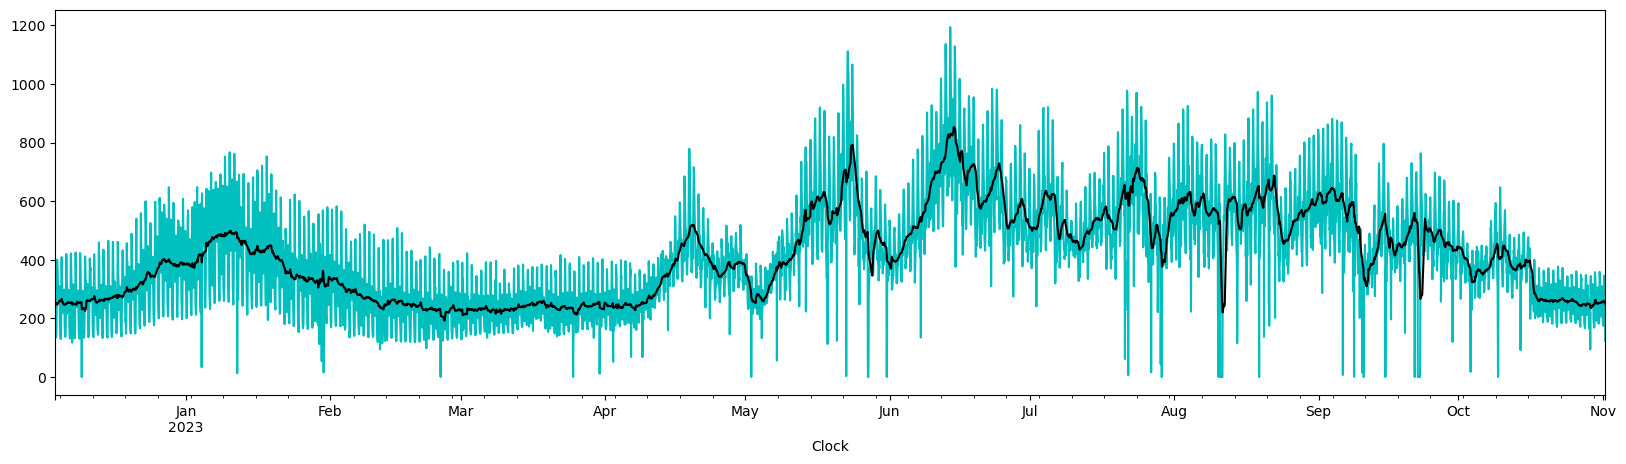

In [16]:
df['Kwh'].plot(color='c')
df['Kwh_r'].plot(color='k')

In [11]:
df2=lst[0]

In [12]:
df2['Kwh'].describe()

count    8332.000000
mean     1231.005713
std       502.267511
min         0.000000
25%       854.175000
50%      1180.800000
75%      1535.750000
max      3397.200000
Name: Kwh, dtype: float64

In [13]:
df2['Kwh_r'].describe()

count    8332.000000
mean     1230.777655
std       410.106005
min       593.683333
25%       831.705208
50%      1188.760417
75%      1573.029167
max      2273.358333
Name: Kwh_r, dtype: float64

In [14]:
result=adfuller(df2['Kwh_r'],autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -3.0325141711575867
p-value: 0.031967542818221895
Critical Values: {'1%': -3.431138396323342, '5%': -2.8618884164019005, '10%': -2.5669554572202125}


In [15]:
result=adfuller(df2['Kwh'],autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -3.0948425262201607
p-value: 0.026937226462572607
Critical Values: {'1%': -3.4311382062666165, '5%': -2.8618883324211724, '10%': -2.56695541251651}


<Axes: xlabel='Clock'>

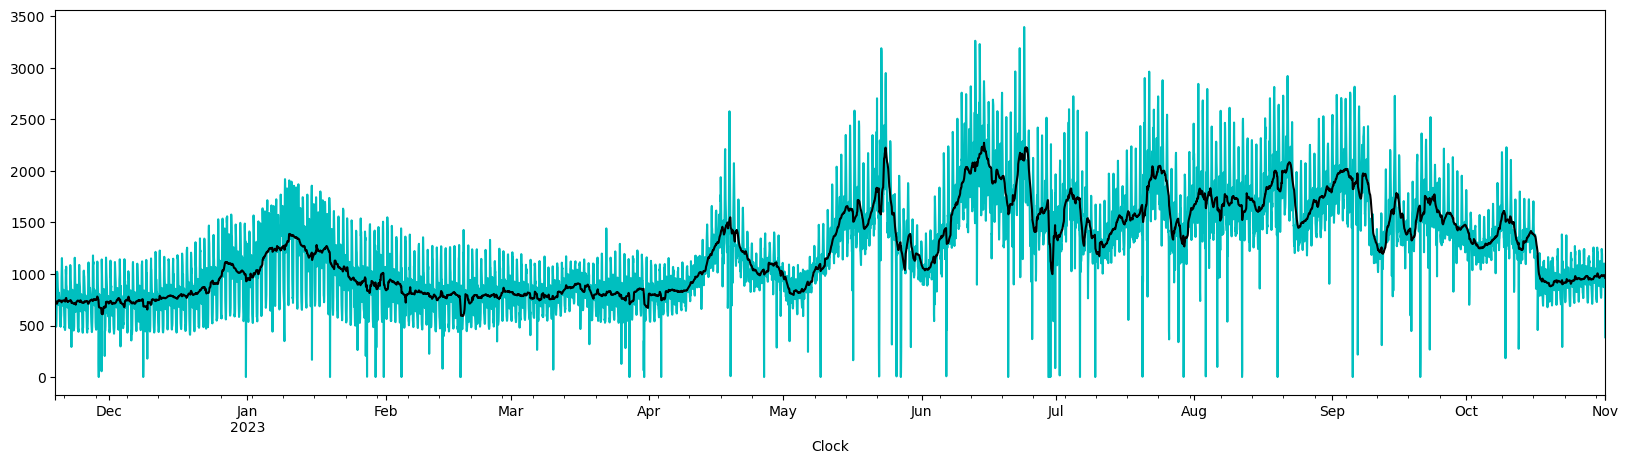

In [17]:
df2['Kwh'].plot(color='c')
df2['Kwh_r'].plot(color='k')